<a href="https://colab.research.google.com/github/vlad131293/RecSys/blob/main/lastfm_dataset_360k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LastFM Dataset 360k analysis

In [ ]:
!curl http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz -LJo lastfm-dataset-360K.tar.gz
!tar -xvzf lastfm-dataset-360K.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542M  100  542M    0     0  1606k      0  0:05:46  0:05:46 --:--:-- 1809k
lastfm-dataset-360K/
lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv
lastfm-dataset-360K/README.txt
lastfm-dataset-360K/mbox_sha1sum.py
lastfm-dataset-360K/usersha1-profile.tsv


In [ ]:
! pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara
! pip install lightfm

  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-af95bvyb/polara_e8ea9797c5cb4f748884c7b4faf45efb
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-af95bvyb/polara_e8ea9797c5cb4f748884c7b4faf45efb
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done


In [ ]:
! wget https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar6/evaluation.py -O evaluation.py
! wget https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar4/dataprep.py -O dataprep.py
! wget https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar4/evaluation.py -O evaluation_knn.py
! wget https://raw.githubusercontent.com/vlad131293/RecSys/main/lfm.py -O lfm.py

--2023-12-25 14:47:27--  https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar6/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1958 (1.9K) [text/plain]
Saving to: ‘evaluation.py’

evaluation.py       100%[===================>]   1.91K  --.-KB/s    in 0s      

2023-12-25 14:47:27 (20.2 MB/s) - ‘evaluation.py’ saved [1958/1958]

--2023-12-25 14:47:27--  https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar4/dataprep.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, vstack
from datetime import datetime
from tqdm.auto import tqdm
from collections import defaultdict

from lightfm import LightFM
from lightfm.data import Dataset

from polara.evaluation.pipelines import random_grid
from polara.recommender.data import RecommenderData
from polara.lib.earlystopping import early_stopping_callback
from polara.tools.display import print_frames
from polara.preprocessing.dataframes import matrix_from_observations

from lfm import build_lfm_model

from dataprep import leave_last_out, transform_indices, reindex_data, verify_time_split, generate_interactions_matrix, to_numeric_id
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = "svg"

This dataset contains `<user, artist, plays>` tuples (for ~360,000 users) collected from Last.fm API (https://www.last.fm/).

The data is formatted one entry per line as follows (tab separated "\t"):
- File usersha1-artmbid-artname-plays.tsv:
      user-mboxsha1 \t musicbrainz-artist-id \t artist-name \t plays
- File usersha1-profile.tsv:
      user-mboxsha1 \t gender (m|f|empty) \t age (int|empty) \t country (str|empty) \t signup (date|empty)

In [ ]:
user_plays_df = pd.read_csv("lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", sep='\t',
                            names=["user_id", "artist_id", "artist_name", "plays"], nrows=1000000)  # the dataset is huge, so we take only a part of it
user_plays_df.head()

,user_id,artist_id,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [ ]:
user_plays_df.apply('nunique')

user_id        20465
artist_id      66798
artist_name    80409
plays           5716
dtype: int64

In [ ]:
len(user_plays_df)

1000000

In [ ]:
user_profile_df = pd.read_csv("lastfm-dataset-360K/usersha1-profile.tsv", sep='\t',
                              names=["user_id", "gender", "age", "country", "signup"])
user_profile_df.head()

,user_id,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


In [ ]:
users = user_profile_df[user_profile_df["user_id"].isin(user_plays_df["user_id"])]
users = users.set_index('user_id')
users.head()

,gender,age,country,signup
user_id,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


In [ ]:
len(users)

20465

## Visualizing data

Let's visualize user-artist interactions.

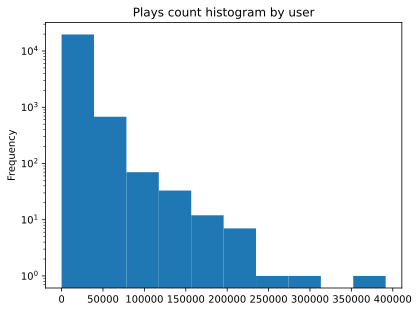

In [ ]:
user_plays_df.groupby("user_id")["plays"].sum().plot.hist(title="Plays count histogram by user", xlabel="plays", ylabel="count", logy=True);

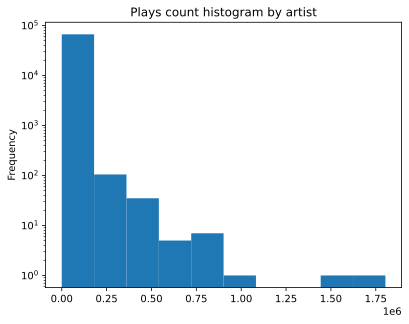

In [ ]:
user_plays_df.groupby("artist_id")["plays"].sum().plot.hist(title="Plays count histogram by artist", xlabel="plays", ylabel="count", logy=True);

And also take a look at user features.

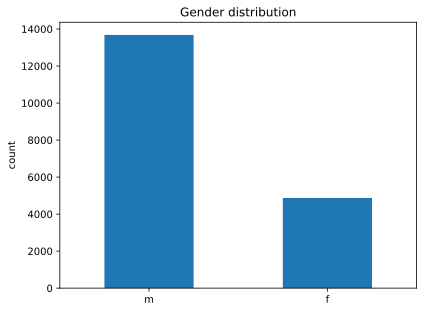

In [ ]:
users["gender"].value_counts().plot.bar(title="Gender distribution", ylabel="count", rot=0);

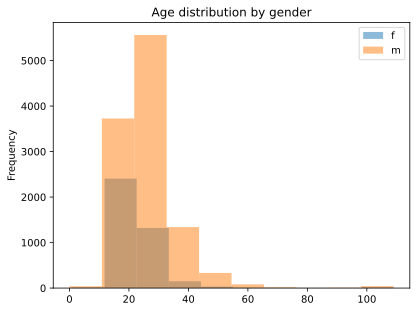

In [ ]:
users["age"].clip(0, 120, inplace=True)
users.groupby("gender")["age"].plot.hist(title="Age distribution by gender", xlabel="age", ylabel="count", alpha=0.5, legend=True);

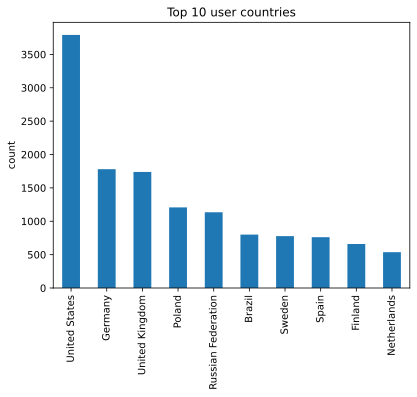

In [ ]:
users["country"].value_counts().nlargest(10).plot.bar(title="Top 10 user countries", ylabel="count");

## Cleanup data

In [ ]:
user_plays_df.isna().sum()

user_id            0
artist_id      12832
artist_name        7
plays              0
dtype: int64

In [ ]:
user_plays_df = user_plays_df.dropna(subset=["artist_id", "artist_name"], how="all")

There are a lot of Null values in `artist_id`; we will map missing values through the column `artist_name`, as `artist_id` and `artist_name` are in a 1-to-1 relationship. We will fill in Null values there with generated UUIDs.

In [ ]:
artist_name_to_id = user_plays_df[["artist_id", "artist_name"]].set_index("artist_name")

In [ ]:
import uuid

def process_nan(x):
  return str(uuid.uuid4())

artist_name_to_id["artist_id"] = artist_name_to_id["artist_id"].apply(lambda x: process_nan(x) if x is np.nan else x)

In [ ]:
artist_name_to_id

,artist_id
artist_name,
betty blowtorch,3bd73256-3905-4f3a-97e2-8b341527f805
die Ärzte,f2fb0ff0-5679-42ec-a55c-15109ce6e320
melissa etheridge,b3ae82c2-e60b-4551-a76d-6620f1b456aa
elvenking,3d6bbeb7-f90e-4d10-b440-e153c0d10b53
juliette & the licks,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8
...,...
sum 41,f2eef649-a6d5-4114-afba-e50ab26254d2
bayside,5f821136-9935-403c-abb5-e78ddda35e9f
scary kids scaring kids,90cda7b7-9112-4ec7-9d6f-3f4675ef5130


In [ ]:
user_plays_df = user_plays_df.set_index("artist_name").fillna(artist_name_to_id).reset_index()

In [ ]:
user_plays_df.isna().sum()

artist_name    7
user_id        0
artist_id      0
plays          0
dtype: int64

## Preprocess data

We don't need column `artist_name` for recsys model.

In [ ]:
data = user_plays_df.drop(["artist_name"], axis=1)
data.head()

,user_id,artist_id,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,706


User features are located in `users` dataframe.

In [ ]:
users.head()

,gender,age,country,signup
user_id,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


Let's split data into train and test.

In [ ]:
def split_random(data, userid):
    holdout = data.sample(frac=1.).sort_values('plays').drop_duplicates(
        subset=[userid], keep='last'
    )
    remaining = data.drop(holdout.index)
    return remaining, holdout

In [ ]:
test_users = data["user_id"].value_counts()[data["user_id"].value_counts() > 10].sample(500).index.tolist()

training_ = data[~data.user_id.isin(test_users)]
testing_ = data[data.user_id.isin(test_users)]

In [ ]:
data_description = dict(
    users = 'user_id',
    items = 'artist_id',
    feedback = 'plays',
    n_users = training_.user_id.nunique(),
    n_items = data.artist_id.nunique(),
)
data_description

{'users': 'user_id',
 'items': 'artist_id',
 'feedback': 'plays',
 'n_users': 19965,
 'n_items': 79630}

In [ ]:
data_description_test = dict(
    users = 'user_id',
    items = 'artist_id',
    feedback = 'plays',
    n_users = testing_.user_id.nunique(),
    n_items = data.artist_id.nunique(),
)
data_description_test

{'users': 'user_id',
 'items': 'artist_id',
 'feedback': 'plays',
 'n_users': 500,
 'n_items': 79630}

In [ ]:
testset_, holdout_ = split_random(testing_, 'user_id')
holdout_ = holdout_.sort_values('user_id')
testset_ = testset_.sort_values('user_id')

In [ ]:
_, full_data_index = transform_indices(data, 'user_id', 'artist_id')
training = reindex_data(training_, full_data_index, entities='items', filter_invalid=True).sort_values('user_id')

holdout = reindex_data(holdout_, full_data_index, entities='items', filter_invalid=True).sort_values('user_id')
testset = reindex_data(testset_, full_data_index, entities='items', filter_invalid=True).sort_values('user_id')

## Create matrix of interactions

In [ ]:
def generate_interactions_matrix(data, data_description, rebase_users=False):
    '''
    Convert pandas dataframe with interactions into a sparse matrix.
    Allows reindexing user ids, which help ensure data consistency
    at the scoring stage (assumes user ids are sorted in scoring array).
    '''
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data[data_description['users']].values # type your code here
    if rebase_users:
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data[data_description['items']].values # type your code here
    feedback = data[data_description['feedback']].values # type your code here
    # construct rating matrix
    return csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items))

In [ ]:
train_matrix = generate_interactions_matrix(training, data_description, rebase_users=True)
train_matrix

<19965x79630 sparse matrix of type '<class 'numpy.int64'>'
	with 975035 stored elements in Compressed Sparse Row format>

In [130]:
print("{:.2f}%".format(train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1]) * 100))

0.06%


In [ ]:
test_matrix = generate_interactions_matrix(testset, data_description_test, rebase_users=True)
test_matrix

<500x79630 sparse matrix of type '<class 'numpy.int64'>'
	with 24446 stored elements in Compressed Sparse Row format>

## Create user features

In [ ]:
users.isna().sum()

gender     1914
age        4343
country       0
signup        0
dtype: int64

In [ ]:
def get_user_features(data: pd.DataFrame):
  data = data.copy()
  data = data.drop(["signup"], axis=1)
  data["age"].fillna(data["age"].median(), inplace=True)
  data["age"] = data["age"].astype(int)
  # data["gender"] = data["gender"].apply(lambda x: "u" if x not in ("f", "m") else x)
  # data = pd.get_dummies(data, columns=['gender', 'country'])
  user_features = csr_matrix(data.values)

  return user_features

In [ ]:
users.head()

,gender,age,country,signup
user_id,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


In [ ]:
# to encode categorical properly, we need to do it for all users to preserve dimensions
users["gender"] = users["gender"].apply(lambda x: "u" if x not in ("f", "m") else x)
users = pd.get_dummies(users, columns=['gender', 'country'])

In [ ]:
train_users_data = users[~users.index.isin(test_users)]
test_users_data = users[users.index.isin(test_users)]

In [ ]:
train_user_features = get_user_features(train_users_data)
test_user_features = get_user_features(test_users_data)
test_user_features

<500x179 sparse matrix of type '<class 'numpy.int64'>'
	with 1500 stored elements in Compressed Sparse Row format>

## Build model

In [ ]:
data_description['user_features'] = train_user_features
data_description['item_features'] = None
data_description

{'users': 'user_id',
 'items': 'artist_id',
 'feedback': 'plays',
 'n_users': 19965,
 'n_items': 79630,
 'user_features': <19965x179 sparse matrix of type '<class 'numpy.int64'>'
 	with 59893 stored elements in Compressed Sparse Row format>,
 'item_features': None}

In [ ]:
data_description_test['user_features'] = test_user_features
data_description_test['item_features'] = None
data_description_test

{'users': 'user_id',
 'items': 'artist_id',
 'feedback': 'plays',
 'n_users': 500,
 'n_items': 79630,
 'user_features': <500x179 sparse matrix of type '<class 'numpy.int64'>'
 	with 1500 stored elements in Compressed Sparse Row format>,
 'item_features': None}

## Train model

In [ ]:
lfm_config = dict(
    no_components = 100,
    loss = 'warp',
    max_sampled = 1,
    max_epochs = 100,
    learning_schedule = 'adagrad',
    user_alpha = 1e-3,
    item_alpha = 1e-3,
    random_state = 7032023
)

lfm_model = build_lfm_model(
    lfm_config,
    train_matrix,
    data_description,
    iterator = tqdm
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
user_biases, user_embeddings = lfm_model.get_user_representations(features=train_user_features)
item_biases, item_embeddings  = lfm_model.get_item_representations()
user_embeddings.shape, item_embeddings.shape

((19965, 100), (79630, 100))

In [ ]:
full_user_features = vstack([train_user_features, test_user_features])
full_user_features

<20465x179 sparse matrix of type '<class 'numpy.int64'>'
	with 61393 stored elements in Compressed Sparse Row format>

## Predictions

In [ ]:
def lightfm_scoring(model, data, data_description, item_bias=True):
    """
    A standard scoring function adopted for use with LightFM in the user cold-start settings.
    """
    dtype = 'i4'
    test_users = data_description['test_users'].astype(dtype)
    all_items = np.arange(data_description['n_items']).astype(dtype)
    item_index, user_index = np.meshgrid(all_items, test_users, copy=False)

    item_biases = model.item_biases.copy()

    if item_bias:
        model.item_biases *= 0
    lfm_scores = model.predict(
        user_index.ravel(),
        item_index.ravel(),
        user_features = data_description['user_features'],
        item_features = data_description['item_features'],
    )
    model.item_biases[:] = item_biases
    scores = lfm_scores.reshape(len(test_users), len(all_items))
    return scores

def coldstart_evaluate(recommended, holdout, data_description, topn=20):
    """
    Evaluates the performance of a recommender system for item cold-start scenario.
    It takes in `recommended_users` - a 2D array of recommended users for each cold item in the holdout.
    It returns a dictionary containing with evaluation metrics.
    """
    holdout_items = holdout[data_description['items']].values
    assert recommended.shape[0] == len(holdout_items)

    hits_mask = recommended[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_items = recommended.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_items
    cov = len(np.unique(recommended.ravel())) / data_description['n_items']
    ndcg = np.sum(1 / np.log2(1+hit_rank)) / n_test_items
    return {'hr': hr, 'mrr': mrr, 'cov': cov, 'ndcg': ndcg}

## Cold case
Matrix of interactions is empty, only user features are available.

In [ ]:
scoring_description = dict(
    test_users = np.arange(data_description['n_users'], data.user_id.nunique()),
    user_features = vstack([train_user_features, test_user_features]),
    item_features = None,
    n_items = data_description['n_items']
)

In [ ]:
lfm_scores = lightfm_scoring(lfm_model, None, scoring_description, False)
downvote_seen_items(lfm_scores, testset, data_description_test)
lfm_scores.shape

(500, 79630)

In [ ]:
topn = 50
lfm_recs = topn_recommendations(lfm_scores, topn=topn)
metrics = coldstart_evaluate(lfm_recs, holdout, data_description_test, topn=topn)
metrics

{'hr': 0.166,
 'mrr': 0.03861412430701905,
 'cov': 0.003692075850809996,
 'ndcg': 0.0634600397964632}

## Warm case
All data is available.

In [ ]:
lfm_model.fit_partial(
    interactions=vstack([train_matrix, test_matrix]),
    user_features=full_user_features,
    epochs=10
)

In [ ]:
lfm_scores = lightfm_scoring(lfm_model, None, scoring_description, False)
downvote_seen_items(lfm_scores, testset, data_description_test)
lfm_scores.shape

(500, 79630)

In [ ]:
topn = 50
lfm_recs = topn_recommendations(lfm_scores, topn=topn)
warm_metrics = coldstart_evaluate(lfm_recs, holdout, data_description_test, topn=topn)
warm_metrics

{'hr': 0.178,
 'mrr': 0.039626596202443465,
 'cov': 0.003616727364058772,
 'ndcg': 0.06606698821359862}

## Intermediate case

Estimating the effect of the number of interactions on the number of recomendations.

In [ ]:
def sampling_interactions(data: pd.DataFrame, num_interactions: int) -> pd.DataFrame:
    """
    Для каждого пользователя семлируется заданное число интеракций и возвращается
    новый dataframe
    """
    return testset.groupby('user_id').sample(num_interactions)

In [ ]:
result_metrics = defaultdict(list)
topn = 30
for num in tqdm(range(10)):
    lfm_model = build_lfm_model(
        lfm_config,
        train_matrix,
        data_description
    )
    current_testset = sampling_interactions(testset, num)
    current_matrix = generate_interactions_matrix(
        current_testset, data_description_test, rebase_users=True
    )
    current_matrix = vstack([train_matrix, current_matrix])
    lfm_model.fit_partial(
        interactions=current_matrix,
        user_features=full_user_features,
        epochs=10
    )
    lfm_scores = lightfm_scoring(lfm_model, None, scoring_description, False)
    downvote_seen_items(lfm_scores, testset, data_description_test)
    lfm_recs = topn_recommendations(lfm_scores, topn=topn)

    metrics = coldstart_evaluate(lfm_recs, holdout, data_description_test, topn=topn)
    result_metrics[num].append(metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

In [113]:
curves = defaultdict(list)
keys = list(result_metrics[0][0].keys())
for i in result_metrics:
    for key in keys:
        temp = []
        for exp in result_metrics[i]:
            temp.append(exp[key])
        curves[key].append(temp)
for key in keys:
    curves[key] = np.array(curves[key]).T

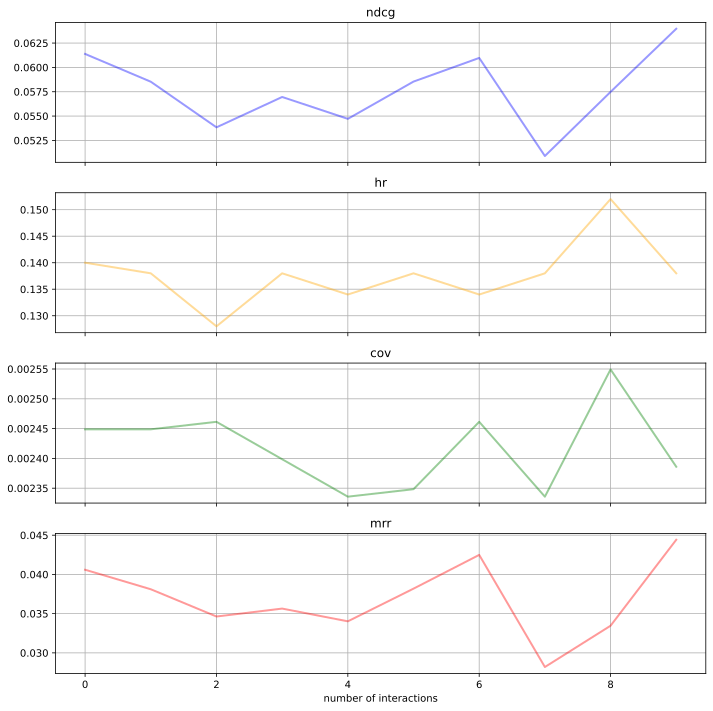

In [125]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(curves["ndcg"][0], color='b', alpha=0.4, linewidth=2)
axs[0].set_title('ndcg')
axs[0].grid(True)

axs[1].plot(curves["hr"][0], color='orange', alpha=0.4, linewidth=2)
axs[1].set_title('hr')
axs[1].grid(True)

axs[2].plot(curves["cov"][0], color='green', alpha=0.4, linewidth=2)
axs[2].set_title('cov')
axs[2].grid(True)

axs[3].plot(curves["mrr"][0], color='red', alpha=0.4, linewidth=2)
axs[3].set_title('mrr')
axs[3].grid(True)

plt.xlabel("number of interactions")

# Убираем лишние оси
for ax in axs.flat:
    ax.label_outer()

# Настройка расстояния между графиками
plt.tight_layout()

# Показать всю фигуру с графиками
plt.show()